In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.models import Sequential

from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPool2D, LSTM
from keras.layers import Reshape, Flatten, Dropout, Concatenate, BatchNormalization
from keras.layers import SpatialDropout1D, concatenate, TimeDistributed
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D

from keras.callbacks import Callback
from keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings 
warnings.filterwarnings(action = 'ignore') 

Using TensorFlow backend.


In [2]:
# Import precleaned text data
input_prefix = 'yelp_cleaned_pos_cr'

df_train = pd.read_csv(input_prefix + '_train.csv')
df_test = pd.read_csv(input_prefix + '_test.csv')

In [3]:
# Split of targets
y_train = df_train['target']
y_test = df_test['target']

In [4]:
# Split off POS Counts and % data
X_pos_train = df_train.drop(['target', 'text'], axis=1).values
X_pos_test = df_test.drop(['target', 'text'], axis=1).values

In [5]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_train.text)

X_train = tokenizer.texts_to_sequences(df_train.text)
X_test = tokenizer.texts_to_sequences(df_test.text)

# Save total number of words in vocabulary to be used later
vocab_size = len(tokenizer.word_index) + 1

In [6]:
# Set max length of text vector for each article
maxlen = 2000

# Pad articles with fewer than maxlen tokens
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [7]:
X_train = np.append(X_train, X_pos_train, axis=1)

In [8]:
# Undersample positive judgements to balance classes
rus = RandomUnderSampler(random_state=0)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
X_pos_train_us = X_train_us[:, -X_pos_train.shape[1]:]
X_train_us = X_train_us[:,:-X_pos_train.shape[1]]

In [9]:
# Oversample positive judgements to balance classes
ros = RandomOverSampler(random_state=0)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)
X_pos_train_os = X_train_os[:, -X_pos_train.shape[1]:]
X_train_os = X_train_os[:,:-X_pos_train.shape[1]]

In [10]:
# Oversample positive judgements using SMOTE to balance classes
sm = SMOTE(random_state=13)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
X_pos_train_sm = X_train_sm[:, -X_pos_train.shape[1]:]
X_train_sm = X_train_sm[:,:-X_pos_train.shape[1]]

In [11]:
X_pos_train = X_train[:, -X_pos_train.shape[1]:]
X_train = X_train[:,:-X_pos_train.shape[1]]

In [12]:
print(X_train.shape, X_pos_train.shape, 
      X_train_us.shape, X_pos_train_us.shape,
      X_train_os.shape, X_pos_train_os.shape, 
      X_train_sm.shape, X_pos_train_sm.shape,
      X_test.shape, X_pos_test.shape)

(10261, 2000) (10261, 136) (598, 2000) (598, 136) (19924, 2000) (19924, 136) (19924, 2000) (19924, 136) (2054, 2000) (2054, 136)


In [13]:
# One Hot encode target data
encoder = OneHotEncoder(sparse=False)

y_train = encoder.fit_transform(y_train.values.reshape(-1,1))
y_test = encoder.fit_transform(y_test.values.reshape(-1,1))
y_train_us = encoder.fit_transform(y_train_us.reshape(-1,1))
y_train_os = encoder.fit_transform(y_train_os.reshape(-1,1))
y_train_sm = encoder.fit_transform(y_train_sm.reshape(-1,1))

In [14]:
# Make undersampled Test set
X_test_us = np.append(X_test, X_pos_test, axis=1)

rus = RandomUnderSampler(random_state=0)
X_test_us, y_test_us = rus.fit_resample(X_test_us, y_test)
X_pos_test_us = X_test_us[:, -X_pos_test.shape[1]:]
X_test_us = X_test_us[:,:-X_pos_test.shape[1]]

y_test_us = encoder.fit_transform(y_test_us.reshape(-1,1))

In [15]:
# Define plotting function to show accuracy/loss vs. epoch
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [16]:
def plot_roc(model, X_t, y_t):
    pred_probs = model.predict(X_t)

    fpr, tpr, junk = metrics.roc_curve(y_t, pred_probs[:,1])

    auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='g', lw=2, label='Area Under Curve = {:.3}'.format(auc))
    plt.plot([0,1], [0,1], color='navy', linestyle='--')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Plot')
    plt.legend(loc='lower right')
    plt.show()

In [17]:
def show_results(model, X_t, y_t):
    preds = np.argmax(model.predict(X_t), axis=1)
    print("F1 Score: ", metrics.f1_score(y_t, preds, average=None))
    print("Recall: ", metrics.recall_score(y_t, preds, average=None))
    print("Precision: ", metrics.precision_score(y_t, preds, average=None))

    print(metrics.confusion_matrix(y_t, preds))

    plot_roc(model, X_t, y_t)

In [18]:
# Define function to takea line of GloVe data and return word and vector as an array
def get_coefs(word, *arr):
    try:
        return word, np.asarray(arr, dtype='float32')
    except:
        return None, None

In [19]:
# Read in GloVe word vectors as a dictionary
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(r'C:\Users\brbenson\workspace\nlp\glove.840B.300d.txt', encoding="utf8"))

In [20]:
# Loop through GloVe vectors and remove any of wrong size
embed_size = 300

for k in list(embeddings_index.keys()):
    v = embeddings_index[k]
    try:
        if v.shape != (embed_size, ):
            embeddings_index.pop(k)
    except:
        pass
            
embeddings_index.pop(None)

In [21]:
# Construct a matrix of embedding values to be used as pretrained weights
values = list(embeddings_index.values())
all_embs = np.stack(values)

emb_mean, emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = vocab_size
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= maxlen: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [22]:
# RNN with single GRU layer using pretrained GloVe word embedding vectors 
# and second input of pos count features

inp = Input(shape=(maxlen, ))

x = Embedding(input_dim=vocab_size, 
              output_dim=embed_size, 
              input_length=maxlen, 
              weights=[embedding_matrix], 
              trainable=True)(inp)

x = SpatialDropout1D(0.3)(x)
x = Bidirectional(GRU(100, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

aux_inp = Input(shape=(X_pos_train.shape[1], ))
conc = concatenate([avg_pool, max_pool, aux_inp])

x = Dense(128, activation="sigmoid")(conc)
outp = Dense(2, activation="sigmoid")(x)

model_2 = Model(inputs=[inp, aux_inp], outputs=outp)
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 2000, 300)    7396500     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 2000, 300)    0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
global_ave

2019-04-22 12:34:28.139438
Training Accuracy: 0.9987
Testing Accuracy:  0.9727
2019-04-22 12:44:45.745180


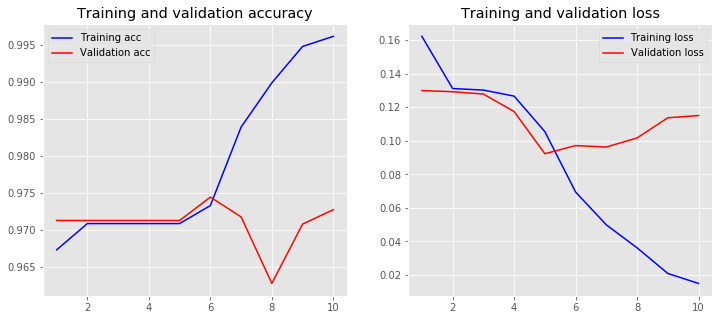

In [24]:
print(datetime.datetime.now())

history_2 = model_2.fit([X_train, X_pos_train], y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=200)

loss, accuracy = model_2.evaluate([X_train, X_pos_train], y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_2.evaluate([X_test, X_pos_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_2)

print(datetime.datetime.now())

In [30]:
preds = np.argmax(model_2.predict([X_test, X_pos_test]), axis=1)
print("F1 Score: ", metrics.f1_score(y_test[:,1], preds, average=None))
print("Recall: ", metrics.recall_score(y_test[:,1], preds, average=None))
print("Precision: ", metrics.precision_score(y_test[:,1], preds, average=None))

metrics.confusion_matrix(y_test[:,1], preds)


F1 Score:  [0.98604883 0.40425532]
Recall:  [0.99197995 0.3220339 ]
Precision:  [0.98018821 0.54285714]


array([[1979,   16],
       [  40,   19]], dtype=int64)

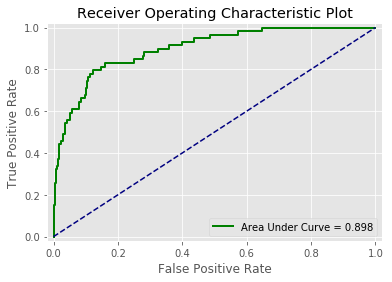

In [50]:
plot_roc(model_2, [X_test, X_pos_test], y_test)

In [51]:
# Undersampled RNN with single GRU layer using pretrained GloVe word embedding vectors 
# and second input of pos count features

inp = Input(shape=(maxlen, ))

x = Embedding(input_dim=vocab_size, 
              output_dim=embed_size, 
              input_length=maxlen, 
              weights=[embedding_matrix], 
              trainable=True)(inp)

x = SpatialDropout1D(0.3)(x)
x = Bidirectional(GRU(100, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

aux_inp = Input(shape=(X_pos_train.shape[1], ))
conc = concatenate([avg_pool, max_pool, aux_inp])

x = Dense(128, activation="sigmoid")(conc)
outp = Dense(2, activation="sigmoid")(x)

model_2_us = Model(inputs=[inp, aux_inp], outputs=outp)
model_2_us.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_2_us.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 2000, 300)    7396500     input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 2000, 300)    0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
global_ave

2019-04-22 14:13:42.086465
Training Accuracy: 1.0000
Testing Accuracy:  0.8615
2019-04-22 14:50:48.530450


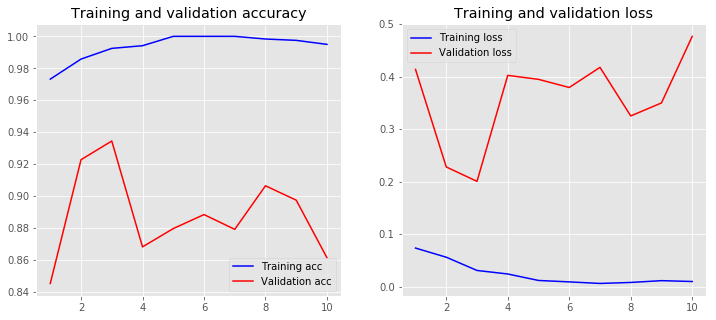

In [57]:
print(datetime.datetime.now())

history_2_us = model_2_us.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=10,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=40)

loss, accuracy = model_2_us.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_2_us.evaluate([X_test, X_pos_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_2_us)

print(datetime.datetime.now())

F1 Score:  [0.92386059 0.24867725]
Recall:  [0.86365915 0.79661017]
Precision:  [0.99308357 0.14733542]
[[1723  272]
 [  12   47]]


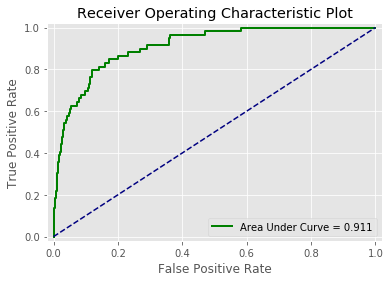

In [58]:
preds = np.argmax(model_2_us.predict([X_test, X_pos_test]), axis=1)
print("F1 Score: ", metrics.f1_score(y_test[:,1], preds, average=None))
print("Recall: ", metrics.recall_score(y_test[:,1], preds, average=None))
print("Precision: ", metrics.precision_score(y_test[:,1], preds, average=None))

print(metrics.confusion_matrix(y_test[:,1], preds))

plot_roc(model_2_us, [X_test, X_pos_test], y_test)

In [22]:
# Undersampled RNN with single GRU layer using pretrained GloVe word embedding vectors 
# and second input of pos count and ratio features

inp = Input(shape=(maxlen, ))

x = Embedding(input_dim=vocab_size, 
              output_dim=embed_size, 
              input_length=maxlen, 
              weights=[embedding_matrix], 
              trainable=True)(inp)

x = SpatialDropout1D(0.3)(x)
x = Bidirectional(GRU(100, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

aux_inp = Input(shape=(X_pos_train.shape[1], ))
conc = concatenate([avg_pool, max_pool, aux_inp])

x = Dense(128, activation="sigmoid")(conc)
outp = Dense(2, activation="sigmoid")(x)

model_2_us2 = Model(inputs=[inp, aux_inp], outputs=outp)
model_2_us2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_2_us2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2000, 300)    7396500     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 2000, 300)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_ave

2019-04-23 13:30:09.534884
Training Accuracy: 1.0000
Testing Accuracy:  0.9080
2019-04-23 15:09:08.832583


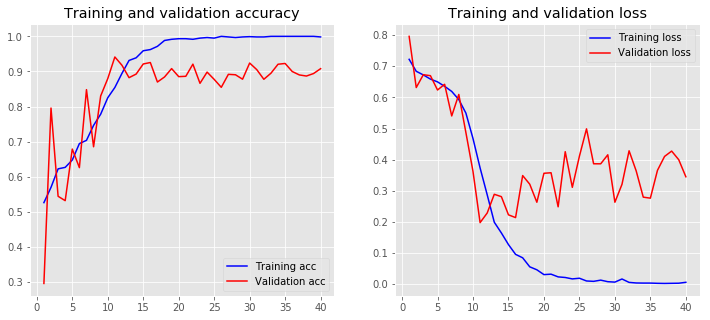

In [23]:
print(datetime.datetime.now())

history_2_us2 = model_2_us2.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=40,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=100)

loss, accuracy = model_2_us2.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_2_us2.evaluate([X_test, X_pos_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_2_us2)

print(datetime.datetime.now())

F1 Score:  [0.95101615 0.3037037 ]
Recall:  [0.91478697 0.69491525]
Precision:  [0.99023332 0.1943128 ]
[[1825  170]
 [  18   41]]


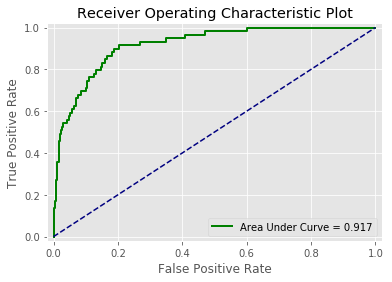

In [24]:
show_results(model_2_us2, [X_test, X_pos_test], y_test[:,1])

In [45]:
# Undersampled RNN with single GRU layer using pretrained GloVe word embedding vectors 
# and second input of pos count and ratio features

inp = Input(shape=(maxlen, ))

x = Embedding(input_dim=vocab_size, 
              output_dim=embed_size, 
              input_length=maxlen, 
              weights=[embedding_matrix], 
              trainable=True)(inp)

x = SpatialDropout1D(0.3)(x)
x = Bidirectional(GRU(100, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

aux_inp = Input(shape=(X_pos_train.shape[1], ))
conc = concatenate([avg_pool, max_pool, aux_inp])

x = Dense(128, activation="sigmoid")(conc)
outp = Dense(2, activation="sigmoid")(x)

model_2_us3 = Model(inputs=[inp, aux_inp], outputs=outp)
model_2_us3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_2_us3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 2000, 300)    7396500     input_23[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 2000, 300)    0           embedding_12[0][0]               
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_ave

2019-04-24 16:15:57.746949
Training Accuracy: 1.0000
Testing Accuracy:  0.8220
2019-04-24 17:09:10.904976


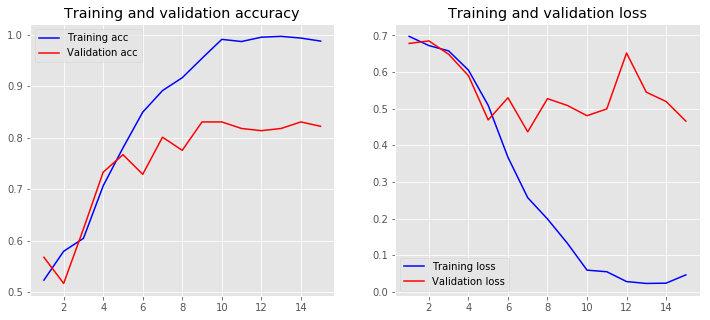

In [46]:
print(datetime.datetime.now())

history_2_us3 = model_2_us3.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=15,
                    verbose=False,
                    validation_data=([X_test_us, X_pos_test_us], y_test_us),
                    batch_size=40)

loss, accuracy = model_2_us3.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_2_us3.evaluate([X_test_us, X_pos_test_us], y_test_us, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_2_us3)

print(datetime.datetime.now())

F1 Score:  [0.80733945 0.83464567]
Recall:  [0.74576271 0.89830508]
Precision:  [0.88       0.77941176]
[[44 15]
 [ 6 53]]


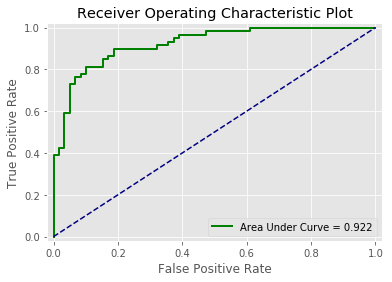

In [47]:
show_results(model_2_us3, [X_test_us, X_pos_test_us], y_test_us[:,1])

In [ ]:
show_results(model_2_us3, [X_test, X_pos_test], y_test[:,1])

In [65]:
# Oversampled RNN with single GRU layer using pretrained GloVe word embedding vectors 
# and second input of pos count features

inp = Input(shape=(maxlen, ))

x = Embedding(input_dim=vocab_size, 
              output_dim=embed_size, 
              input_length=maxlen, 
              weights=[embedding_matrix], 
              trainable=True)(inp)

x = SpatialDropout1D(0.3)(x)
x = Bidirectional(GRU(100, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

aux_inp = Input(shape=(X_pos_train.shape[1], ))
conc = concatenate([avg_pool, max_pool, aux_inp])

x = Dense(128, activation="sigmoid")(conc)
outp = Dense(2, activation="sigmoid")(x)

model_2_os = Model(inputs=[inp, aux_inp], outputs=outp)
model_2_os.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_2_os.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 2000, 300)    7396500     input_12[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_7 (SpatialDro (None, 2000, 300)    0           embedding_7[0][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_7[0][0]        
__________________________________________________________________________________________________
global_ave

2019-04-22 16:07:45.045744
Training Accuracy: 1.0000
Testing Accuracy:  0.9715
2019-04-23 00:41:10.385631


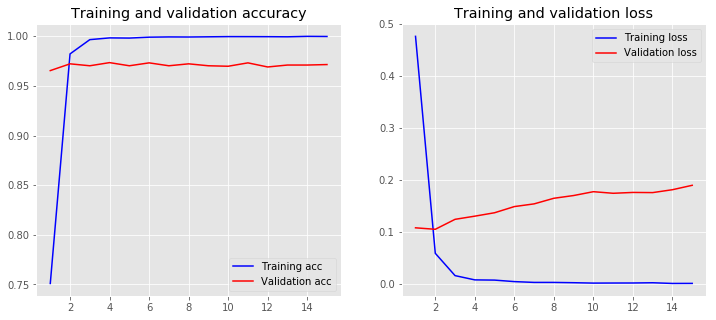

In [66]:
print(datetime.datetime.now())

history_2_os = model_2_os.fit([X_train_os, X_pos_train_os], y_train_os,
                    epochs=15,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=40)

loss, accuracy = model_2_os.evaluate([X_train_os, X_pos_train_os], y_train_os, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_2_os.evaluate([X_test, X_pos_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_2_os)

print(datetime.datetime.now())

F1 Score:  [0.98531973 0.33707865]
Recall:  [0.9924812  0.25423729]
Precision:  [0.97826087 0.5       ]
[[1980   15]
 [  44   15]]


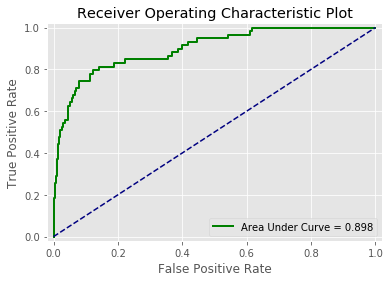

In [67]:
preds = np.argmax(model_2_os.predict([X_test, X_pos_test]), axis=1)
print("F1 Score: ", metrics.f1_score(y_test[:,1], preds, average=None))
print("Recall: ", metrics.recall_score(y_test[:,1], preds, average=None))
print("Precision: ", metrics.precision_score(y_test[:,1], preds, average=None))

print(metrics.confusion_matrix(y_test[:,1], preds))

plot_roc(model_2_os, [X_test, X_pos_test], y_test)

In [68]:
# SMOTE Oversampled RNN with single GRU layer using pretrained GloVe word embedding vectors 
# and second input of pos count features

inp = Input(shape=(maxlen, ))

x = Embedding(input_dim=vocab_size, 
              output_dim=embed_size, 
              input_length=maxlen, 
              weights=[embedding_matrix], 
              trainable=True)(inp)

x = SpatialDropout1D(0.3)(x)
x = Bidirectional(GRU(100, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

aux_inp = Input(shape=(X_pos_train.shape[1], ))
conc = concatenate([avg_pool, max_pool, aux_inp])

x = Dense(128, activation="sigmoid")(conc)
outp = Dense(2, activation="sigmoid")(x)

model_2_sm = Model(inputs=[inp, aux_inp], outputs=outp)
model_2_sm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_2_sm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 2000, 300)    7396500     input_14[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_8 (SpatialDro (None, 2000, 300)    0           embedding_8[0][0]                
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_8[0][0]        
__________________________________________________________________________________________________
global_ave

2019-04-23 00:43:53.278092
Training Accuracy: 1.0000
Testing Accuracy:  0.9503
2019-04-23 09:30:56.201241


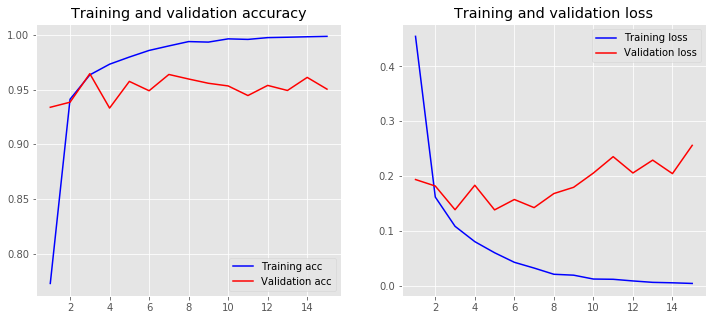

In [69]:
print(datetime.datetime.now())

history_2_sm = model_2_sm.fit([X_train_sm, X_pos_train_sm], y_train_sm,
                    epochs=15,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=200)

loss, accuracy = model_2_sm.evaluate([X_train_sm, X_pos_train_sm], y_train_sm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_2_sm.evaluate([X_test, X_pos_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_2_sm)

print(datetime.datetime.now())

F1 Score:  [0.97434608 0.22727273]
Recall:  [0.97092732 0.25423729]
Precision:  [0.977789   0.20547945]
[[1937   58]
 [  44   15]]


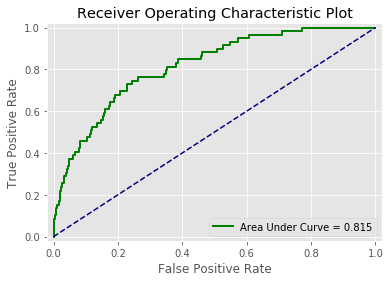

In [70]:
preds = np.argmax(model_2_sm.predict([X_test, X_pos_test]), axis=1)
print("F1 Score: ", metrics.f1_score(y_test[:,1], preds, average=None))
print("Recall: ", metrics.recall_score(y_test[:,1], preds, average=None))
print("Precision: ", metrics.precision_score(y_test[:,1], preds, average=None))

print(metrics.confusion_matrix(y_test[:,1], preds))

plot_roc(model_2_sm, [X_test, X_pos_test], y_test)

In [31]:
# Multi channel CNN (3x) with max pooling and aux input of pos count features
embedding_dim = 300

filter_sizes = [2, 3, 5]
num_filters = 256
drop = 0.3

inputs = Input(shape=(maxlen,), dtype='int32')

embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_0)

maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_1)

maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_2)

concatenated_tensor_1 = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2])

flatten = Flatten()(concatenated_tensor_1)

aux_input = Input(shape=(X_pos_train.shape[1], ))

concatenated_tensor_2 = Concatenate(axis=1)(
    [flatten, aux_input])

dropout = Dropout(drop)(concatenated_tensor_2)
dense = Dense(units=128, activation='sigmoid')(dropout)
output = Dense(units=2, activation='sigmoid')(dense)

model_3 = Model(inputs=[inputs, aux_input], outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 2000, 300)    7396500     input_17[0][0]                   
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 2000, 300, 1) 0           embedding_9[0][0]                
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 1999, 1, 256) 153856      reshape_9[0][0]                  
__________________________________________________________________________________________________
conv2d_26 

2019-04-23 16:00:06.499210
Training Accuracy: 0.9709
Testing Accuracy:  0.9713
2019-04-24 07:22:19.809547


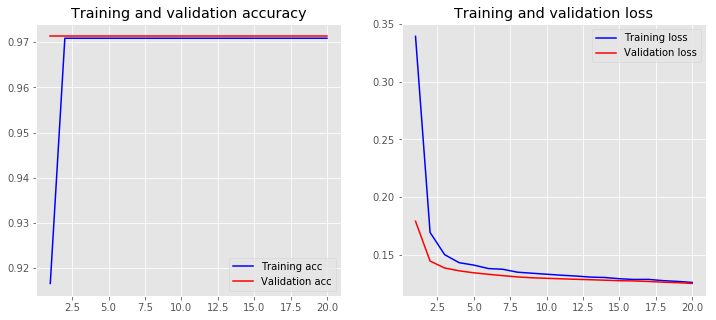

In [32]:
print(datetime.datetime.now())

history_3 = model_3.fit([X_train, X_pos_train], y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=200)

loss, accuracy = model_3.evaluate([X_train, X_pos_train], y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_3.evaluate([X_test, X_pos_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_3)

print(datetime.datetime.now())

F1 Score:  [0.9854285 0.       ]
Recall:  [1. 0.]
Precision:  [0.97127556 0.        ]
[[1995    0]
 [  59    0]]


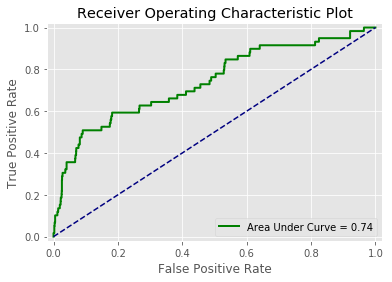

In [38]:
show_results(model_3, [X_test, X_pos_test], y_test[:,1])

In [33]:
# Undersampled Multi channel CNN (3x) with max pooling and aux input of pos count features
embedding_dim = 300

filter_sizes = [2, 3, 5]
num_filters = 256
drop = 0.3

inputs = Input(shape=(maxlen,), dtype='int32')

embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_0)

maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_1)

maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_2)

concatenated_tensor_1 = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2])

flatten = Flatten()(concatenated_tensor_1)

aux_input = Input(shape=(X_pos_train.shape[1], ))

concatenated_tensor_2 = Concatenate(axis=1)(
    [flatten, aux_input])

dropout = Dropout(drop)(concatenated_tensor_2)
dense = Dense(units=128, activation='sigmoid')(dropout)
output = Dense(units=2, activation='sigmoid')(dense)

model_3_us = Model(inputs=[inputs, aux_input], outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_3_us.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_3_us.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 2000, 300)    7396500     input_19[0][0]                   
__________________________________________________________________________________________________
reshape_10 (Reshape)            (None, 2000, 300, 1) 0           embedding_10[0][0]               
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 1999, 1, 256) 153856      reshape_10[0][0]                 
__________________________________________________________________________________________________
conv2d_29 

2019-04-24 11:53:06.427415
Training Accuracy: 0.9482
Testing Accuracy:  0.6928
2019-04-24 12:24:23.299481


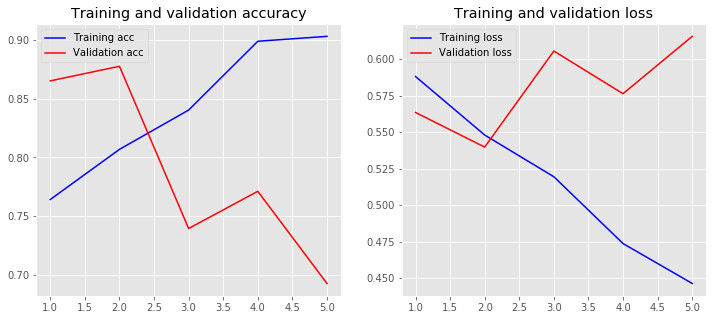

In [39]:
print(datetime.datetime.now())

history_3_us = model_3_us.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=5,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=20)

loss, accuracy = model_3_us.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_3_us.evaluate([X_test, X_pos_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_3_us)

print(datetime.datetime.now())

F1 Score:  [0.81614614 0.12605042]
Recall:  [0.69423559 0.76271186]
Precision:  [0.98999285 0.06870229]
[[1385  610]
 [  14   45]]


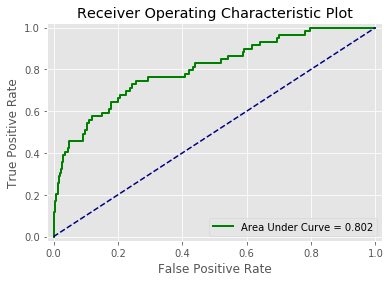

In [40]:
show_results(model_3_us, [X_test, X_pos_test], y_test[:,1])

In [48]:
# Oversampled Multi channel CNN (3x) with max pooling and 
# aux input of pos count and ratiofeatures
embedding_dim = 300

filter_sizes = [2, 3, 5]
num_filters = 256
drop = 0.3

inputs = Input(shape=(maxlen,), dtype='int32')

embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_0)

maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_1)

maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_2)

concatenated_tensor_1 = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2])

flatten = Flatten()(concatenated_tensor_1)

aux_input = Input(shape=(X_pos_train.shape[1], ))

concatenated_tensor_2 = Concatenate(axis=1)(
    [flatten, aux_input])

dropout = Dropout(drop)(concatenated_tensor_2)
dense = Dense(units=128, activation='sigmoid')(dropout)
output = Dense(units=2, activation='sigmoid')(dense)

model_3_os = Model(inputs=[inputs, aux_input], outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_3_os.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_3_os.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 2000, 300)    7396500     input_25[0][0]                   
__________________________________________________________________________________________________
reshape_12 (Reshape)            (None, 2000, 300, 1) 0           embedding_13[0][0]               
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 1999, 1, 256) 153856      reshape_12[0][0]                 
__________________________________________________________________________________________________
conv2d_35 

In [ ]:
print(datetime.datetime.now())

history_3_os = model_3_os.fit([X_train_os, X_pos_train_os], y_train_os,
                    epochs=30,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=300)

loss, accuracy = model_3_os.evaluate([X_train_os, X_pos_train_os], y_train_os, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_3_os.evaluate([X_test, X_pos_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_3_os)

print(datetime.datetime.now())

2019-04-24 17:09:30.969607


F1 Score:  [0.98710957 0.2972973 ]
Recall:  [0.99799499 0.18644068]
Precision:  [0.97645905 0.73333333]
[[1991    4]
 [  48   11]]


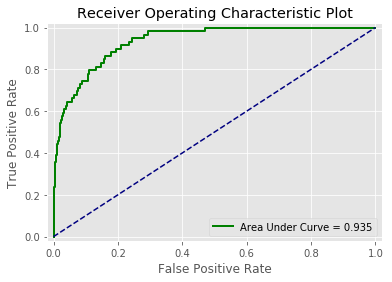

In [52]:
show_results(model_3_os, [X_test, X_pos_test], y_test[:,1])

In [54]:
# Undersampled RNN + CNN (Single layer each) using GloVe vectors
# and aux input of PoS counts and ratios

inp = Input(shape=(maxlen, ))
x = Embedding(vocab_size, 
              embedding_dim, 
              weights=[embedding_matrix], 
              input_length=maxlen, 
              trainable=True)(inp)

x = SpatialDropout1D(0.1)(x)
x = Bidirectional(GRU(100, return_sequences=True))(x)

x = Conv1D(128, 
           kernel_size = 5, 
           padding = "valid", 
           kernel_initializer = "he_uniform")(x)

aux_inp = Input(shape=(X_pos_train.shape[1], ))

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool, aux_inp])

x = Dense(64, activation="sigmoid")(conc)
outp = Dense(2, activation="sigmoid")(x)

model_4_us = Model(inputs=[inp, aux_inp], outputs=outp)
model_4_us.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_4_us.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 2000, 300)    7396500     input_29[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 2000, 300)    0           embedding_15[0][0]               
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
conv1d_1 (

2019-04-25 15:14:07.486546
Training Accuracy: 1.0000
Testing Accuracy:  0.8051
2019-04-25 16:29:10.835208


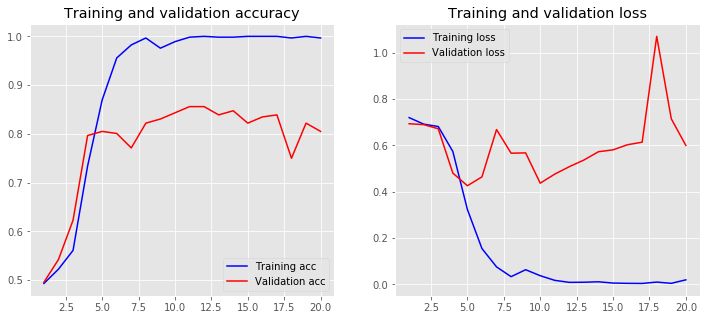

In [56]:
print(datetime.datetime.now())

history_4_us = model_4_us.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=20,
                    verbose=False,
                    validation_data=([X_test_us, X_pos_test_us], y_test_us),
                    batch_size=20)

loss, accuracy = model_4_us.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_4_us.evaluate([X_test_us, X_pos_test_us], y_test_us, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_4_us)

print(datetime.datetime.now())

F1 Score:  [0.79646018 0.81300813]
Recall:  [0.76271186 0.84745763]
Precision:  [0.83333333 0.78125   ]
[[45 14]
 [ 9 50]]


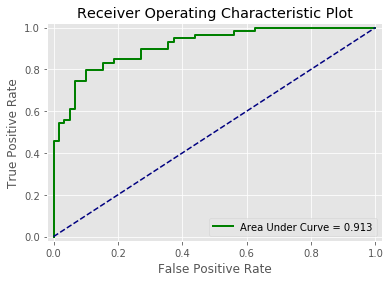

In [57]:
show_results(model_4_us, [X_test_us, X_pos_test_us], y_test_us[:,1])

F1 Score:  [0.87762532 0.18621974]
Recall:  [0.78546366 0.84745763]
Precision:  [0.99428934 0.10460251]
[[1567  428]
 [   9   50]]


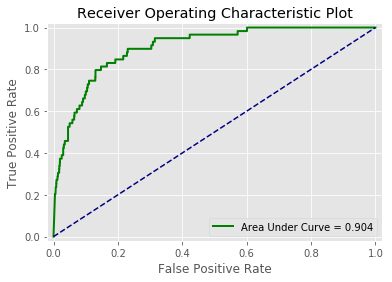

In [58]:
show_results(model_4_us, [X_test, X_pos_test], y_test[:,1])

In [22]:
# Undersampled RNN + CNN (Single layer each) using GloVe vectors
# and aux input of PoS counts and ratios
embedding_dim = 300

inp = Input(shape=(maxlen, ))
x = Embedding(vocab_size, 
              embedding_dim, 
              weights=[embedding_matrix], 
              input_length=maxlen, 
              trainable=True)(inp)

x = SpatialDropout1D(0.1)(x)
x = Bidirectional(GRU(100, return_sequences=True))(x)

x = Conv1D(128, 
           kernel_size = 5, 
           padding = "valid", 
           kernel_initializer = "he_uniform")(x)

aux_inp = Input(shape=(X_pos_train.shape[1], ))

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool, aux_inp])

x = Dense(64, activation="sigmoid")(conc)
outp = Dense(2, activation="sigmoid")(x)

model_4_us2 = Model(inputs=[inp, aux_inp], outputs=outp)
model_4_us2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_4_us2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2000, 300)    7396500     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 2000, 300)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_1 (

2019-04-26 13:35:49.427639
Training Accuracy: 1.0000
Testing Accuracy:  0.7966
2019-04-26 15:32:48.002325


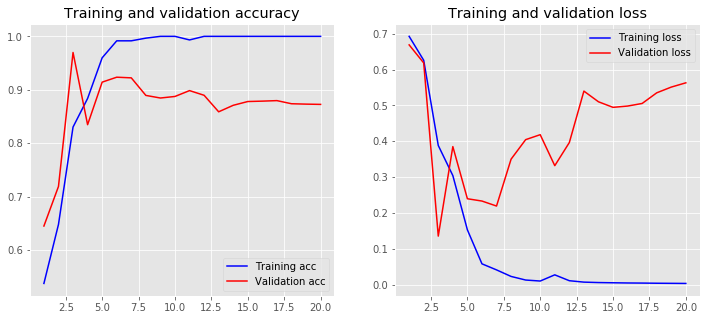

In [23]:
print(datetime.datetime.now())

history_4_us2 = model_4_us2.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=20,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=20)

loss, accuracy = model_4_us2.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_4_us2.evaluate([X_test_us, X_pos_test_us], y_test_us, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_4_us2)

print(datetime.datetime.now())

F1 Score:  [0.93043016 0.23391813]
Recall:  [0.87819549 0.6779661 ]
Precision:  [0.9892716  0.14134276]
[[1752  243]
 [  19   40]]


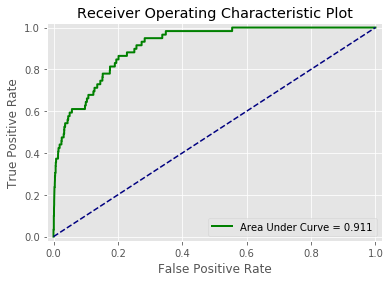

In [24]:
show_results(model_4_us2, [X_test, X_pos_test], y_test[:,1])

F1 Score:  [0.81818182 0.76923077]
Recall:  [0.91525424 0.6779661 ]
Precision:  [0.73972603 0.88888889]
[[54  5]
 [19 40]]


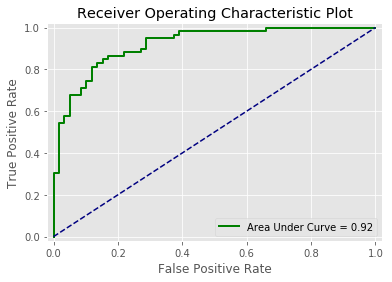

In [25]:
show_results(model_4_us2, [X_test_us, X_pos_test_us], y_test_us[:,1])

In [30]:
# Undersampled Multi Channel CNN (3x) with max pooling feeding into RNN (LSTM)
# with aux input of PoS counts and ratios

filter_sizes = [2, 3, 5]
num_filters = 256
drop = 0.3

inputs = Input(shape=(maxlen,), dtype='int32')

embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_0)

maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_1)

maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2])

lstm = TimeDistributed(Bidirectional(LSTM(128, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

flatten = Flatten()(lstm)
dropout = Dropout(drop)(flatten)

aux_input = Input(shape=(X_pos_train.shape[1], ))

concatenated_tensor_2 = Concatenate(axis=1)(
    [dropout, aux_input])

dense = Dense(units=128, activation='sigmoid')(concatenated_tensor_2)
output = Dense(units=2, activation='sigmoid')(dense)

model_5_us = Model(inputs=[inputs, aux_input], outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_5_us.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_5_us.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 2000, 300)    7396500     input_11[0][0]                   
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 2000, 300, 1) 0           embedding_6[0][0]                
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 1999, 1, 256) 153856      reshape_5[0][0]                  
__________________________________________________________________________________________________
conv2d_14 

2019-04-26 16:11:04.542033
Training Accuracy: 1.0000
Testing Accuracy:  0.8178
2019-04-26 17:58:29.365021


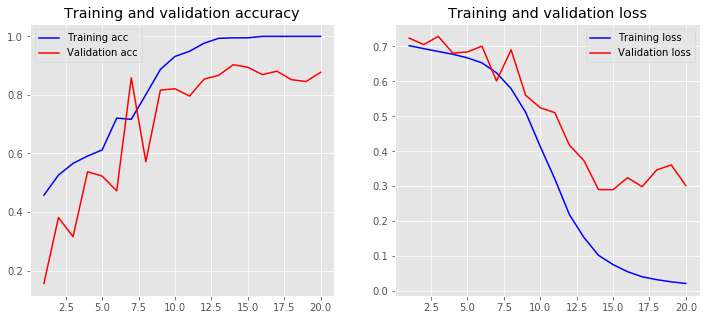

In [31]:
print(datetime.datetime.now())

history_5_us = model_5_us.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=20,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=20)

loss, accuracy = model_5_us.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_5_us.evaluate([X_test_us, X_pos_test_us], y_test_us, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_5_us)

print(datetime.datetime.now())

F1 Score:  [0.93322734 0.24550898]
Recall:  [0.88270677 0.69491525]
Precision:  [0.98988196 0.14909091]
[[1761  234]
 [  18   41]]


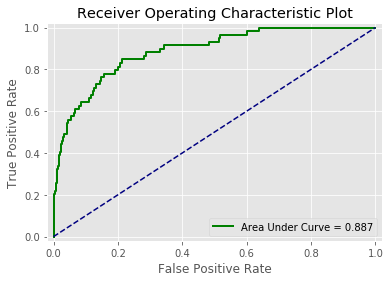

In [32]:
show_results(model_5_us, [X_test, X_pos_test], y_test[:,1])

F1 Score:  [0.84210526 0.7961165 ]
Recall:  [0.94915254 0.69491525]
Precision:  [0.75675676 0.93181818]
[[56  3]
 [18 41]]


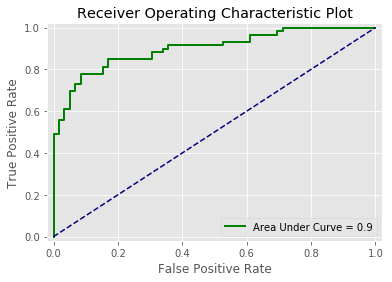

In [33]:
show_results(model_5_us, [X_test_us, X_pos_test_us], y_test_us[:,1])

In [39]:
# Undersampled Multi Channel CNN (3x) with max pooling feeding into RNN (LSTM)
# with aux input of PoS counts and ratios

filter_sizes = [2, 3, 5]
num_filters = 256
drop = 0.3

inputs = Input(shape=(maxlen,), dtype='int32')

embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_0)

maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_1)

maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2])

lstm = TimeDistributed(Bidirectional(LSTM(128, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

flatten = Flatten()(lstm)
dropout = Dropout(drop)(flatten)

aux_input = Input(shape=(X_pos_train.shape[1], ))

concatenated_tensor_2 = Concatenate(axis=1)(
    [dropout, aux_input])

dense = Dense(units=128, activation='sigmoid')(concatenated_tensor_2)
output = Dense(units=2, activation='sigmoid')(dense)

model_5_us2 = Model(inputs=[inputs, aux_input], outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_5_us2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_5_us2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 2000, 300)    7396500     input_8[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2000, 300, 1) 0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1999, 1, 256) 153856      reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

2019-04-29 14:30:47.911206
Training Accuracy: 1.0000
Testing Accuracy:  0.8051
2019-04-29 15:30:34.155000


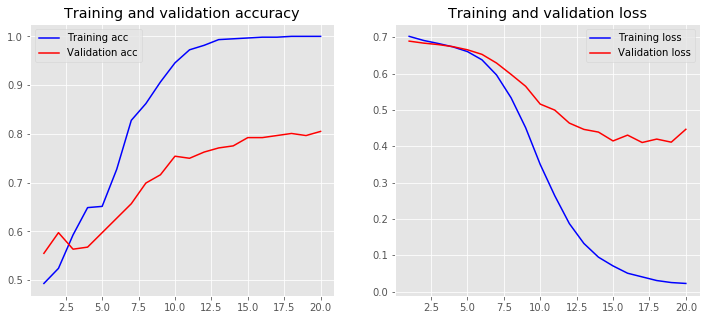

In [40]:
print(datetime.datetime.now())

history_5_us2 = model_5_us2.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=20,
                    verbose=False,
                    validation_data=([X_test_us, X_pos_test_us], y_test_us),
                    batch_size=20)

loss, accuracy = model_5_us2.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_5_us2.evaluate([X_test_us, X_pos_test_us], y_test_us, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_5_us2)

print(datetime.datetime.now())

F1 Score:  [0.82962963 0.77227723]
Recall:  [0.94915254 0.66101695]
Precision:  [0.73684211 0.92857143]
[[56  3]
 [20 39]]


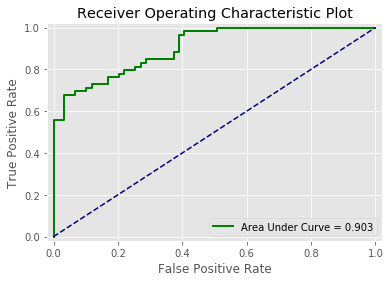

In [41]:
show_results(model_5_us2, [X_test_us, X_pos_test_us], y_test_us[:,1])

F1 Score:  [0.94086728 0.25742574]
Recall:  [0.89724311 0.66101695]
Precision:  [0.98895028 0.15983607]
[[1790  205]
 [  20   39]]


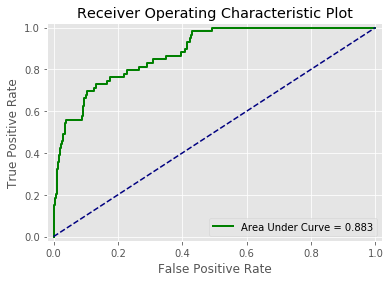

In [42]:
show_results(model_5_us2, [X_test, X_pos_test], y_test[:,1])

In [30]:
# Undersampled RNN (GRU) feeding into Multi Channel CNN (4x) with max pooling
# and auxilary input of PoS counts and ratios trained in bursts to track results

embedding_dim = 300
filter_sizes = [1, 2, 3, 5]
num_filters = 256
drop = 0.3

inputs = Input(shape=(maxlen,), dtype='int32')
embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

x = SpatialDropout1D(0.2)(embedding)
x = Bidirectional(GRU(100, return_sequences=True))(x)

conv_0 = Conv1D(64, kernel_size = filter_sizes[0], padding = "valid", kernel_initializer = "he_uniform")(x)

conv_1 = Conv1D(64, kernel_size = filter_sizes[1], padding = "valid", kernel_initializer = "he_uniform")(x)

conv_2 = Conv1D(64, kernel_size = filter_sizes[2], padding = "valid", kernel_initializer = "he_uniform")(x)

conv_3 = Conv1D(64, kernel_size = filter_sizes[3], padding = "valid", kernel_initializer = "he_uniform")(x)

maxpool_0 = GlobalMaxPooling1D()(conv_0)

maxpool_1 = GlobalMaxPooling1D()(conv_1)

maxpool_2 = GlobalMaxPooling1D()(conv_2)

maxpool_3 = GlobalMaxPooling1D()(conv_3)

concatenated_tensor = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2, maxpool_3])

flatten = Dense(units=128, activation='sigmoid')(concatenated_tensor)
dropout = Dropout(drop)(flatten)

aux_input = Input(shape=(X_pos_train.shape[1], ))

concatenated_tensor_2 = Concatenate(axis=1)(
    [dropout, aux_input])

dense = Dense(units=128, activation='sigmoid')(concatenated_tensor_2)

output = Dense(units=2, activation='sigmoid')(dense)

model_6_us = Model(inputs=[inputs, aux_input], outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_6_us.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_6_us.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 2000, 300)    7396500     input_6[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 2000, 300)    0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
conv1d_9 (

2019-04-29 11:22:40.933285
Training Accuracy: 0.7860
Testing Accuracy:  0.7997
2019-04-29 12:30:26.560016


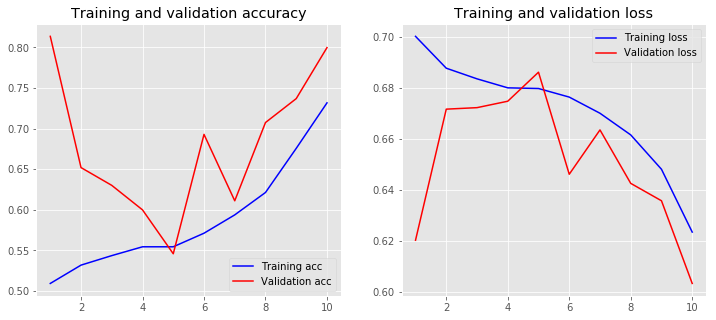

In [31]:
print(datetime.datetime.now())

history_6_us = model_6_us.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=10,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=20)

loss, accuracy = model_6_us.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_6_us.evaluate([X_test, X_pos_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_6_us)

print(datetime.datetime.now())

2019-04-29 12:37:04.265573
Training Accuracy: 0.9716
Testing Accuracy:  0.8939
2019-04-29 13:46:46.883217


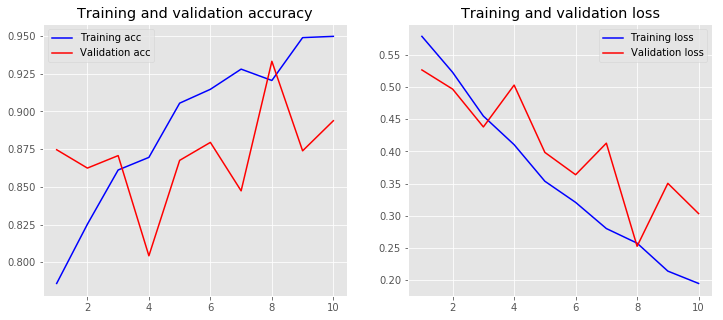

In [34]:
print(datetime.datetime.now())

history_6_us = model_6_us.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=10,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=20)

loss, accuracy = model_6_us.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_6_us.evaluate([X_test, X_pos_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_6_us)

print(datetime.datetime.now())

F1 Score:  [0.94225722 0.26174497]
Recall:  [0.89974937 0.66101695]
Precision:  [0.98898072 0.16317992]
[[1795  200]
 [  20   39]]


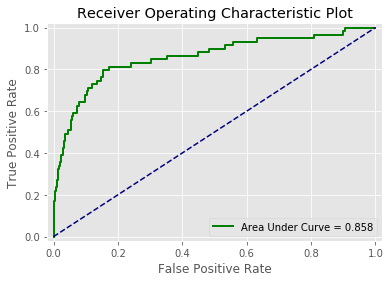

In [35]:
show_results(model_6_us, [X_test, X_pos_test], y_test[:,1])

F1 Score:  [0.81203008 0.75728155]
Recall:  [0.91525424 0.66101695]
Precision:  [0.72972973 0.88636364]
[[54  5]
 [20 39]]


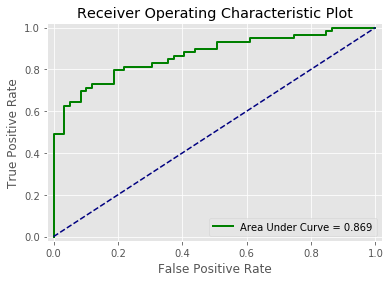

In [36]:
show_results(model_6_us, [X_test_us, X_pos_test_us], y_test_us[:,1])

2019-04-29 14:01:32.016858
Training Accuracy: 0.9833
Testing Accuracy:  0.8508
2019-04-29 14:24:04.264431


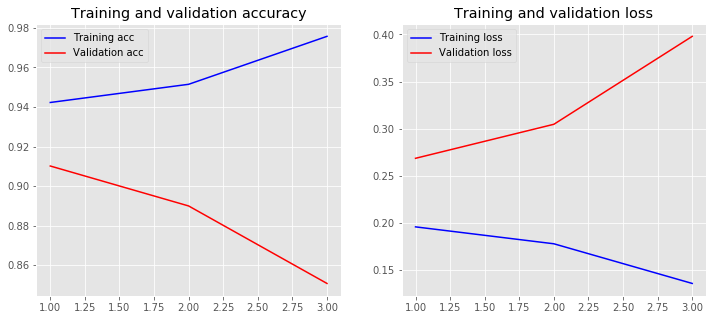

In [37]:
print(datetime.datetime.now())

history_6_us = model_6_us.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=3,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=20)

loss, accuracy = model_6_us.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_6_us.evaluate([X_test, X_pos_test], y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_6_us)

print(datetime.datetime.now())

F1 Score:  [0.91707054 0.21827411]
Recall:  [0.85363409 0.72881356]
Precision:  [0.99069226 0.12835821]
[[1703  292]
 [  16   43]]


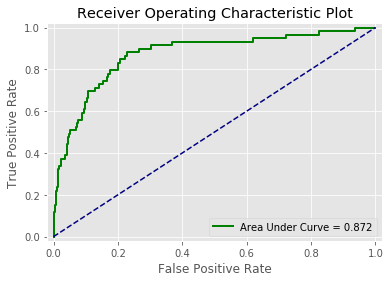

In [38]:
show_results(model_6_us, [X_test, X_pos_test], y_test[:,1])

In [22]:
# Undersampled RNN (GRU) feeding into Multi Channel CNN (4x) with max pooling
# and auxilary input of PoS counts and ratios

embedding_dim = 300
filter_sizes = [1, 2, 3, 5]
num_filters = 256
drop = 0.3

inputs = Input(shape=(maxlen,), dtype='int32')
embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

x = SpatialDropout1D(0.2)(embedding)
x = Bidirectional(GRU(100, return_sequences=True))(x)

conv_0 = Conv1D(64, kernel_size = filter_sizes[0], padding = "valid", kernel_initializer = "he_uniform")(x)

conv_1 = Conv1D(64, kernel_size = filter_sizes[1], padding = "valid", kernel_initializer = "he_uniform")(x)

conv_2 = Conv1D(64, kernel_size = filter_sizes[2], padding = "valid", kernel_initializer = "he_uniform")(x)

conv_3 = Conv1D(64, kernel_size = filter_sizes[3], padding = "valid", kernel_initializer = "he_uniform")(x)

maxpool_0 = GlobalMaxPooling1D()(conv_0)

maxpool_1 = GlobalMaxPooling1D()(conv_1)

maxpool_2 = GlobalMaxPooling1D()(conv_2)

maxpool_3 = GlobalMaxPooling1D()(conv_3)

concatenated_tensor = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2, maxpool_3])

flatten = Dense(units=128, activation='sigmoid')(concatenated_tensor)
dropout = Dropout(drop)(flatten)

aux_input = Input(shape=(X_pos_train.shape[1], ))

concatenated_tensor_2 = Concatenate(axis=1)(
    [dropout, aux_input])

dense = Dense(units=128, activation='sigmoid')(concatenated_tensor_2)

output = Dense(units=2, activation='sigmoid')(dense)

model_6_us2 = Model(inputs=[inputs, aux_input], outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_6_us2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_6_us2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2000, 300)    7396500     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 2000, 300)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_1 (

2019-05-01 10:49:32.653241
Training Accuracy: 0.7241
Testing Accuracy:  0.6229
2019-05-01 11:26:43.200396


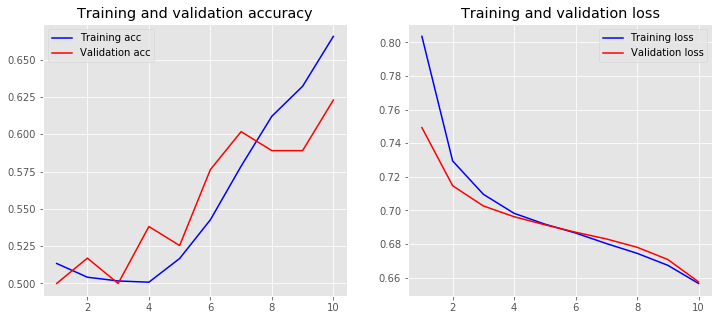

In [23]:
print(datetime.datetime.now())

history_6_us2 = model_6_us2.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=10,
                    verbose=False,
                    validation_data=([X_test_us, X_pos_test_us], y_test_us),
                    batch_size=20)

loss, accuracy = model_6_us2.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_6_us2.evaluate([X_test_us, X_pos_test_us], y_test_us, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_6_us2)

print(datetime.datetime.now())

2019-05-01 12:21:42.986160
Training Accuracy: 0.9758
Testing Accuracy:  0.7839
2019-05-01 12:56:39.792166


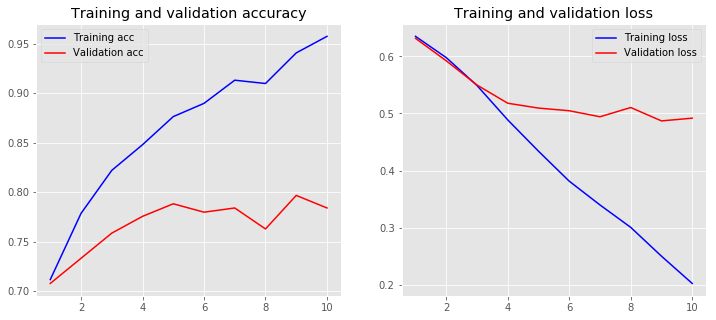

In [26]:
print(datetime.datetime.now())

history_6_us2 = model_6_us2.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=10,
                    verbose=False,
                    validation_data=([X_test_us, X_pos_test_us], y_test_us),
                    batch_size=20)

loss, accuracy = model_6_us2.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_6_us2.evaluate([X_test_us, X_pos_test_us], y_test_us, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_6_us2)

print(datetime.datetime.now())

F1 Score:  [0.80314961 0.7706422 ]
Recall:  [0.86440678 0.71186441]
Precision:  [0.75 0.84]
[[51  8]
 [17 42]]


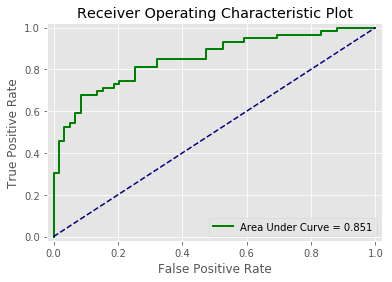

In [27]:
show_results(model_6_us2, [X_test_us, X_pos_test_us], y_test_us[:,1])

F1 Score:  [0.91798871 0.2159383 ]
Recall:  [0.8556391  0.71186441]
Precision:  [0.99013921 0.12727273]
[[1707  288]
 [  17   42]]


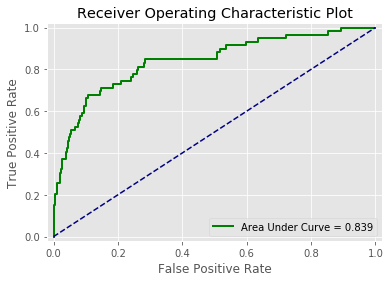

In [28]:
show_results(model_6_us2, [X_test, X_pos_test], y_test[:,1])

In [22]:
# Undersampled Multi Channel CNN (4x) with max pooling feeding into 
# Multi Channel RNN (LSTM 3x)
# Auxilary input of PoS word counts and ratios

embedding_dim = 300

filter_sizes = [1, 2, 3, 5]
num_filters = 256
drop = 0.2

inputs = Input(shape=(maxlen,), dtype='int32')

embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_3 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[3], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_0)

maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_1)

maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_2)

maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_3)

concatenated_tensor = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2, maxpool_3])

lstm_0 = TimeDistributed(Bidirectional(LSTM(64, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

lstm_1 = TimeDistributed(Bidirectional(LSTM(128, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

lstm_2 = TimeDistributed(Bidirectional(LSTM(256, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

concatenated_tensor_2 = Concatenate(axis=2)(
    [lstm_0, lstm_1, lstm_2])

flatten = Flatten()(concatenated_tensor_2)
dropout = Dropout(drop)(flatten)
aux_input = Input(shape=(X_pos_train.shape[1], ))

concatenated_tensor_2 = Concatenate(axis=1)(
    [dropout, aux_input])

dense = Dense(units=128, activation='sigmoid')(concatenated_tensor_2)
output = Dense(units=2, activation='sigmoid')(dense)

model_7_us = Model(inputs=[inputs, aux_input], outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_7_us.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_7_us.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2000, 300)    7396500     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2000, 300, 1) 0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2000, 1, 256) 77056       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

2019-05-02 08:19:51.770105
Training Accuracy: 1.0000
Testing Accuracy:  0.8432
2019-05-02 10:36:43.788629


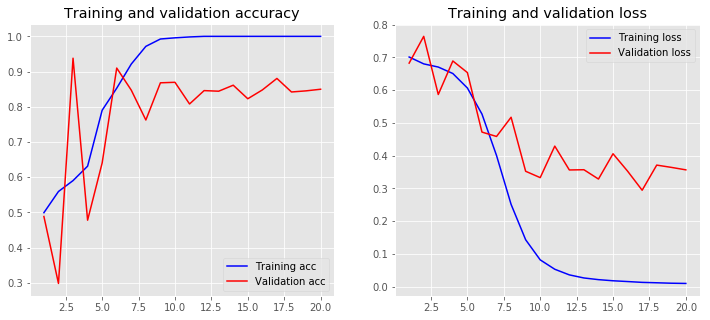

In [23]:
print(datetime.datetime.now())

history_7_us = model_7_us.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=20,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=20)

loss, accuracy = model_7_us.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_7_us.evaluate([X_test_us, X_pos_test_us], y_test_us, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_7_us)

print(datetime.datetime.now())

F1 Score:  [0.91752022 0.23115578]
Recall:  [0.85313283 0.77966102]
Precision:  [0.99241983 0.13569322]
[[1702  293]
 [  13   46]]


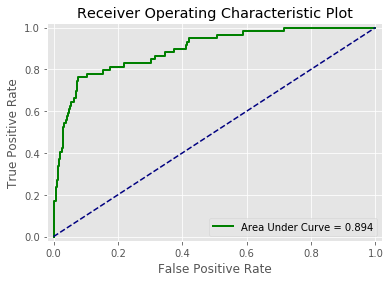

In [24]:
show_results(model_7_us, [X_test, X_pos_test], y_test[:,1])

F1 Score:  [0.83870968 0.82142857]
Recall:  [0.88135593 0.77966102]
Precision:  [0.8        0.86792453]
[[52  7]
 [13 46]]


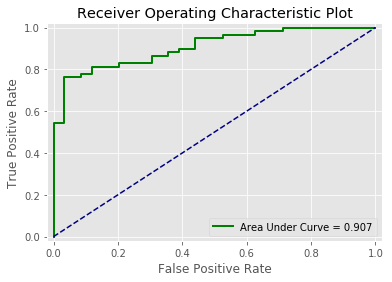

In [25]:
show_results(model_7_us, [X_test_us, X_pos_test_us], y_test_us[:,1])

In [26]:
# Undersampled Multi Channel CNN (4x) with max pooling feeding into 
# Multi Channel RNN (LSTM 3x)
# Auxilary input of PoS word counts and ratios

embedding_dim = 300

filter_sizes = [1, 2, 3, 5]
num_filters = 256
drop = 0.2

inputs = Input(shape=(maxlen,), dtype='int32')

embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_3 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[3], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_0)

maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_1)

maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_2)

maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_3)

concatenated_tensor = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2, maxpool_3])

lstm_0 = TimeDistributed(Bidirectional(LSTM(64, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

lstm_1 = TimeDistributed(Bidirectional(LSTM(128, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

lstm_2 = TimeDistributed(Bidirectional(LSTM(256, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

concatenated_tensor_2 = Concatenate(axis=2)(
    [lstm_0, lstm_1, lstm_2])

flatten = Flatten()(concatenated_tensor_2)
dropout = Dropout(drop)(flatten)
aux_input = Input(shape=(X_pos_train.shape[1], ))

concatenated_tensor_2 = Concatenate(axis=1)(
    [dropout, aux_input])

dense = Dense(units=128, activation='sigmoid')(concatenated_tensor_2)
output = Dense(units=2, activation='sigmoid')(dense)

model_7_us2 = Model(inputs=[inputs, aux_input], outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_7_us2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_7_us2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 2000, 300)    7396500     input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 2000, 300, 1) 0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 2000, 1, 256) 77056       reshape_2[0][0]                  
__________________________________________________________________________________________________
conv2d_6 (

2019-05-02 10:45:57.153406
Training Accuracy: 1.0000
Testing Accuracy:  0.7966
2019-05-02 11:55:59.235838


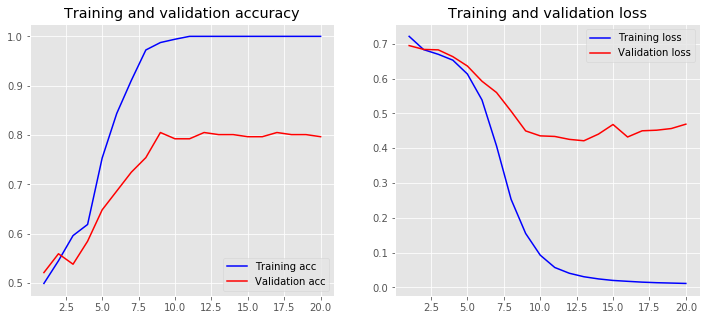

In [27]:
print(datetime.datetime.now())

history_7_us2 = model_7_us2.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=20,
                    verbose=False,
                    validation_data=([X_test_us, X_pos_test_us], y_test_us),
                    batch_size=20)

loss, accuracy = model_7_us2.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_7_us2.evaluate([X_test_us, X_pos_test_us], y_test_us, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_7_us2)

print(datetime.datetime.now())

F1 Score:  [0.9326974  0.23952096]
Recall:  [0.88220551 0.6779661 ]
Precision:  [0.98931984 0.14545455]
[[1760  235]
 [  19   40]]


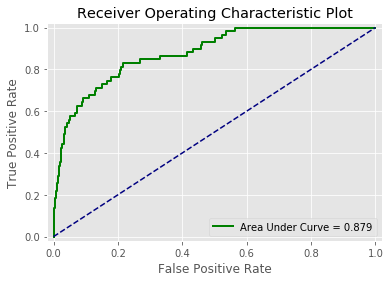

In [28]:
show_results(model_7_us2, [X_test, X_pos_test], y_test[:,1])

F1 Score:  [0.82706767 0.77669903]
Recall:  [0.93220339 0.6779661 ]
Precision:  [0.74324324 0.90909091]
[[55  4]
 [19 40]]


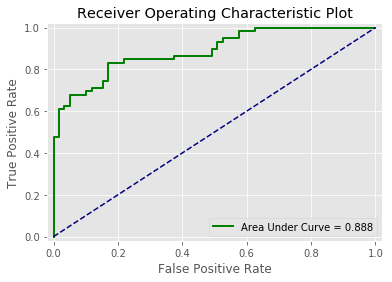

In [29]:
show_results(model_7_us2, [X_test_us, X_pos_test_us], y_test_us[:,1])

In [22]:
# Undersampled Multi Channel CNN (4x) with dropout and batchnorm 
# feeding into Multi Channel RNN (LSTM 3x)
# Auxilary input of PoS word counts and ratios

embedding_dim = 300

filter_sizes = [1, 2, 3, 5]
num_filters = 256
drop = 0.2

inputs = Input(shape=(maxlen,), dtype='int32')

embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)
dropout_0 = Dropout(drop)(conv_0)
batch_0 = BatchNormalization()(dropout_0)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)
dropout_1 = Dropout(drop)(conv_1)
batch_1 = BatchNormalization()(dropout_1)

#conv_2 = Conv2D(num_filters, 
#                kernel_size=(filter_sizes[2], embedding_dim), 
#                padding='valid', kernel_initializer='normal', 
#                activation='relu')(reshape)
#dropout_2 = Dropout(drop)(conv_2)
#batch_2 = BatchNormalization()(dropout_2)

#conv_3 = Conv2D(num_filters, 
#                kernel_size=(filter_sizes[3], embedding_dim), 
#                padding='valid', kernel_initializer='normal', 
#                activation='relu')(reshape)
#dropout_3 = Dropout(drop)(conv_3)
#batch_3 = BatchNormalization()(dropout_3)

concatenated_tensor = Concatenate(axis=1)(
    [batch_0, batch_1])

lstm_0 = TimeDistributed(Bidirectional(LSTM(64, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

lstm_1 = TimeDistributed(Bidirectional(LSTM(128, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

lstm_2 = TimeDistributed(Bidirectional(LSTM(256, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

concatenated_tensor_2 = Concatenate(axis=2)(
    [lstm_0, lstm_1, lstm_2])

flatten = Flatten()(concatenated_tensor_2)
dropout = Dropout(drop)(flatten)
aux_input = Input(shape=(X_pos_train.shape[1], ))

concatenated_tensor_2 = Concatenate(axis=1)(
    [dropout, aux_input])

dense = Dense(units=128, activation='sigmoid')(concatenated_tensor_2)
output = Dense(units=2, activation='sigmoid')(dense)

model_8_us = Model(inputs=[inputs, aux_input], outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_8_us.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_8_us.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2000, 300)    7396500     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2000, 300, 1) 0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2000, 1, 256) 77056       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

2019-05-02 16:36:00.983776
Training Accuracy: 0.9967
Testing Accuracy:  0.7415
2019-05-02 21:25:44.282251


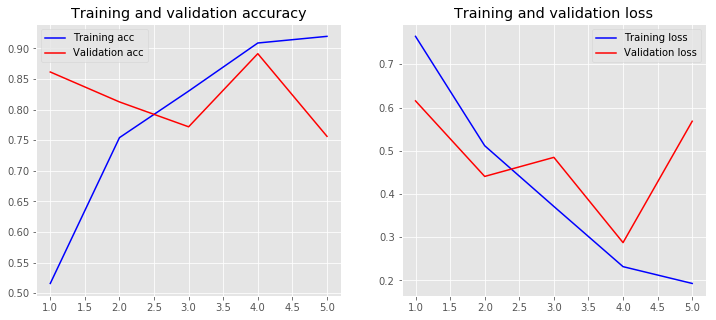

In [23]:
print(datetime.datetime.now())

history_8_us = model_8_us.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=5,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=5)

loss, accuracy = model_8_us.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_8_us.evaluate([X_test_us, X_pos_test_us], y_test_us, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_8_us)

print(datetime.datetime.now())

F1 Score:  [0.85803521 0.14675768]
Recall:  [0.75739348 0.72881356]
Precision:  [0.98952194 0.08159393]
[[1511  484]
 [  16   43]]


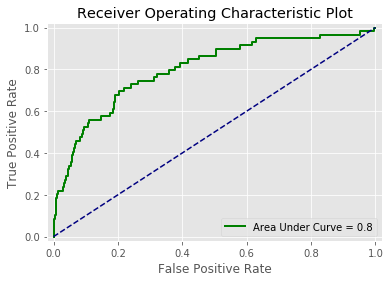

In [24]:
show_results(model_8_us, [X_test, X_pos_test], y_test[:,1])

2019-05-02 22:04:18.401371
Training Accuracy: 1.0000
Testing Accuracy:  0.7161
2019-05-03 02:50:58.888873


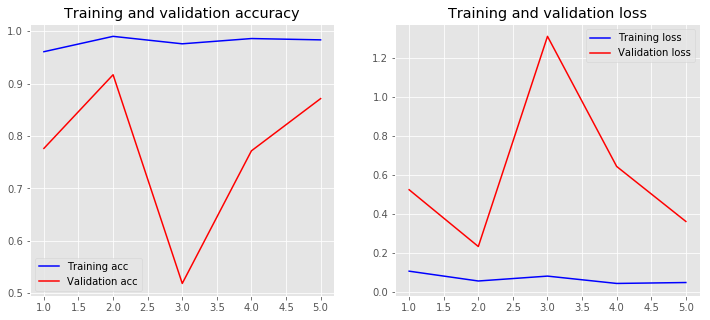

In [25]:
print(datetime.datetime.now())

history_8_us = model_8_us.fit([X_train_us, X_pos_train_us], y_train_us,
                    epochs=5,
                    verbose=False,
                    validation_data=([X_test, X_pos_test], y_test),
                    batch_size=5)

loss, accuracy = model_8_us.evaluate([X_train_us, X_pos_train_us], y_train_us, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_8_us.evaluate([X_test_us, X_pos_test_us], y_test_us, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_8_us)

print(datetime.datetime.now())

F1 Score:  [0.93294615 0.20625   ]
Recall:  [0.88571429 0.55932203]
Precision:  [0.98549916 0.12643678]
[[1767  228]
 [  26   33]]


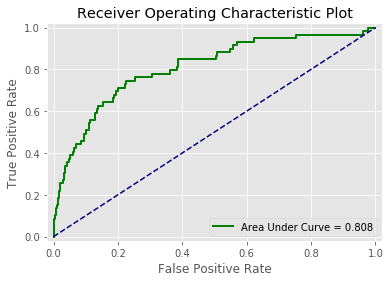

In [26]:
show_results(model_8_us, [X_test, X_pos_test], y_test[:,1])